In [1]:
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt

In [69]:
class Linear:

    def __init__(self,fan_in,fan_out,bias=True):
        self.weight = torch.randn(fan_in,fan_out)/fan_in**0.5
        self.bias = torch.zeros([fan_out]) if bias else None
    
    def __call__(self,x):
        self.out = x @ self.weight
        if self.bias is not None:
            self.out += self.bias
        return self.out
    def parameters(self):
        return [self.weight] +([] if self.bias is None else [self.bias])
class BatchNorm1D:
    def __init__(self,dim,eps=1e-5,momentum=0.1):
        self.eps = eps
        self.momentum = momentum
        self.training= True

        self.gamma = torch.ones(dim)
        self.beta = torch.zeros(dim)

        self.running_mean = torch.zeros(dim)
        self.running_var = torch.ones(dim)

    def __call__(self,x):
        if self.training:
            xmean = x.mean(0,keepdim= True)
            xvar = x.var(0,keepdim = True)
        else:
            xmean = self.running_mean
            xvar = self.running_var
            
        xhat = (x - xmean)/torch.sqrt(self.eps + xvar)
        self.out = self.gamma * xhat + self.beta
        
        if self.training:
            with torch.no_grad():
                self.running_mean = (1-self.momentum)*self.running_mean + self.momentum * xmean
                self.running_var = (1-self.momentum)*self.running_var + self.momentum * xvar

        return self.out

    def parameters(self):
        return [self.gamma,self.beta]
        
class Tanh:
    def __call__(self,x):
        self.out = torch.tanh(x)
        return self.out
    def parameters(self):
        return []

class Embedding:
    def __init__(self,num_embeddings, embedding_dim):
        self.weight = torch.randn((num_embeddings,embedding_dim))
    def __call__(self,IX):
        self.out = self.weight[IX]
        return self.out
    def parameters(self):
        return [self.weight]


class FlattenConsec:
    def __init__(self,n):
        self.n = n

    def __call__(self,x):
        B,T,C = x.shape
        x = x.view(B,T//self.n,C*self.n)
        if x.shape[1] ==1:
            x = x.squeeze(1)
        self.out = x
        return self.out
    def parameters(self):
        return []

class Sequential:
    def __init__(self,layers):
        self.layers = layers
    def __call__(self,x):
        for layer in self.layers:
            x = layer(x)
        self.out = x
        return self.out

    def parameters(self):
        return [p for layer in self.layers for p in layer.parameters()]


    

        


In [70]:
words = open('names.txt','r').read().splitlines()
chars = sorted(list(set(''.join(words))))
stoi = {s:i+1 for i,s in enumerate(chars)}
stoi['.']=0
itos = {i:s for s,i in stoi.items()}
vocab_size=(len(itos))
vocab_size


27

In [84]:
#buidling the dataset
block_size = 8
def build_dataset(words):
    X,Y = [],[]

    for w in words:
        context = [0]*block_size
        for ch in w + '.':
            ix = stoi[ch]
            Y.append(ix)
            X.append(context)
            context = context[1:] +[ix]
    X = torch.tensor(X)
    Y = torch.tensor(Y)
    return X,Y

import random
random.seed(42)
random.shuffle(words)
n1 = int(0.8*len(words))
n2 = int(0.9*len(words))

Xtr, Ytr = build_dataset(words[:n1])
Xdev, Ydev = build_dataset(words[n1:n2])
Xte,Yte = build_dataset(words[n2:])

In [85]:
n_embd = 10
n_hidden = 68
block_size = 8
g = torch.Generator().manual_seed(2147483647)

model = Sequential([
    Embedding(vocab_size,n_embd),
    FlattenConsec(2), Linear(n_embd*2,n_hidden,bias = False), BatchNorm1D(n_hidden), Tanh(),
    FlattenConsec(2), Linear(n_hidden*2,n_hidden,bias = False), BatchNorm1D(n_hidden), Tanh(),
    FlattenConsec(2), Linear(n_hidden*2,n_hidden,bias = False), BatchNorm1D(n_hidden), Tanh(),
    Linear(n_hidden,vocab_size)
])

# with torch.no_grad():
#     layers[-1].weight *= 0.1

parameters = model.parameters()

print(sum(p.nelement() for p in parameters))

for p in parameters:
    p.requires_grad = True

22397


In [86]:
ix = torch.randint(0,Xtr.shape[0],(4,))
Xb, Yb = Xtr[ix], Ytr[ix]
logits = model(Xb)
print(Xb.shape)
Xb

torch.Size([4, 8])


tensor([[ 0,  0,  0,  0,  0,  0, 10,  9],
        [ 0,  0,  0,  0,  0,  0,  1, 22],
        [ 0,  0,  0,  0,  0,  0,  0, 14],
        [ 0,  0,  0,  0,  0,  0, 13,  5]])

In [77]:
model[0].out.shape

TypeError: 'Sequential' object is not subscriptable

In [75]:
for layer in model.layers:
    print(layer.__class__.__name__, ':',tuple(layer.out.shape))

AttributeError: 'Embedding' object has no attribute 'out'

In [87]:
max_steps = 20000
batch_size = 32
lossi = []

for i in range(max_steps):
    #making a batch
    ix = torch.randint(0,Xtr.shape[0],(batch_size,),generator=g)
    Xb,Yb = Xtr[ix], Ytr[ix]

    #forward pass
    logits = model(Xb)

   
    
    
    loss = F.cross_entropy(logits,Yb)

    #backward pass
    for p in parameters:
        p.grad = None
    loss.backward()

    #update
    lr = 0.1 if i<10000 else 0.01
    for p in parameters:
        p.data += -lr*p.grad

    #stats
    if i %1000 ==0:
        print(f'{loss.item():4f}')
    lossi.append(loss.log10().item())

3.389927


2.194704
2.091883
2.613740
2.294282
2.116601
2.065028
2.350849
2.485019
2.193773
1.609886
2.402136
2.241895
1.778708
2.241338
2.543932
1.915020
2.136783
2.175630
2.008740


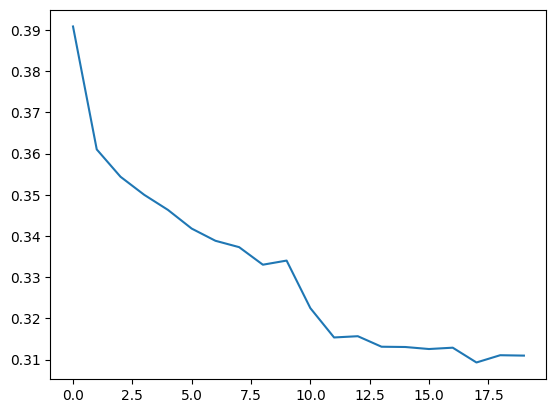

In [81]:
plt.plot(torch.tensor(lossi).view(-1,1000).mean(1))

In [82]:
for layer in model.layers:
    layer.training = False

In [83]:
g = torch.Generator().manual_seed(2147483647 + 10)

for _ in range(20):
    out = []
    context = [0] * block_size
    while True:
        
        logits = model(torch.tensor([context]))
        probs = F.softmax(logits,dim=1)

        ix = torch.multinomial(probs,num_samples=1,generator=g).item()

        context = context[1:] + [ix]

        out.append(ix)

        if ix == 0:
            break

    print(''.join(itos[i] for i in out))


carmah.
amelli.
khitmri.
jehty.
halani.
ejanon.
nadeliah.
jageni.
nelisia.
chaiiv.
kaleigh.
hamon.
catesian.
suline.
liven.
corter.
giearix.
kakari.
dusti.
edde.
